# Recommender System & Association Rules

% pip install pandas

In [57]:
%pip install pandas
%pip install matplotlib
%pip install mlxtend
%pip install scikit-learn
%pip install scipy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.cluster import MiniBatchKMeans

In [ ]:
df_movies = pd.read_csv('./dataset/Netflix_Dataset_Movie.csv')
df_ratings = pd.read_csv('./dataset/Netflix_Dataset_Rating.csv')

### Analisi Statistiche

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB
None
   Movie_ID  Year                          Name
0         1  2003               Dinosaur Planet
1         2  2004    Isle of Man TT 2004 Review
2         3  1997                     Character
3         4  1994  Paula Abdul's Get Up & Dance
4         5  2004      The Rise and Fall of ECW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 4 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
 3   Liked     bool 
dtypes: bool(1), int64(3)
memory usage: 413.4 MB
None
   User_ID  Rating  Movie_ID  Liked
0   712664       5         

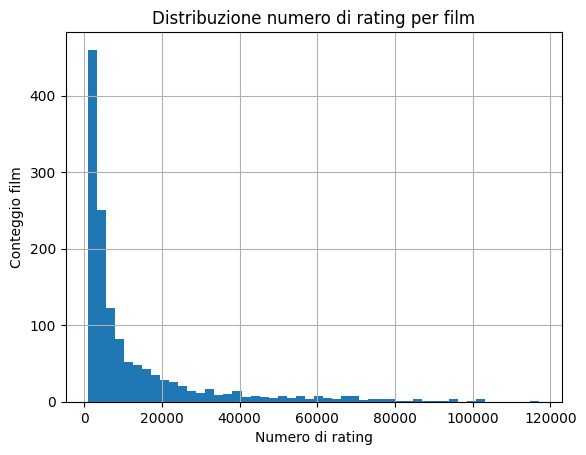

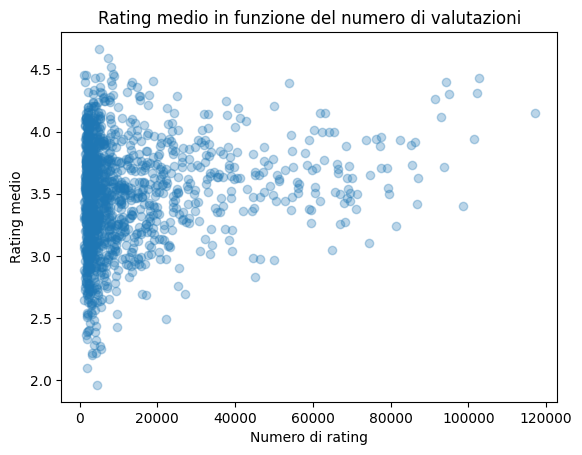

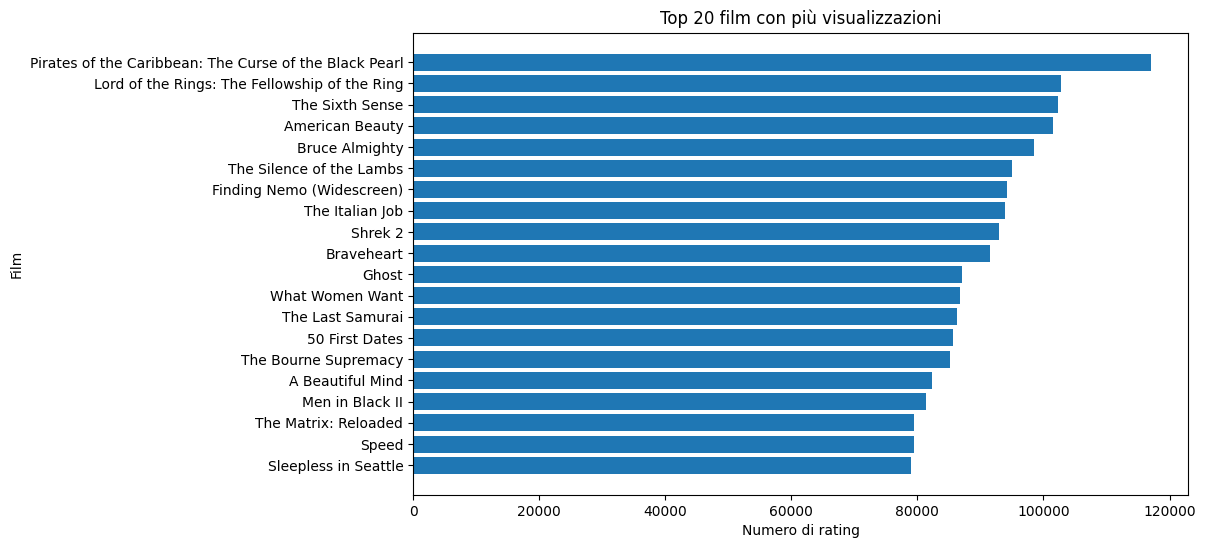

In [ ]:
print(df_movies.info())
print(df_movies.head())

print(df_ratings.info())
print(df_ratings.head())

movie_stats = (
    df_ratings
    .groupby("Movie_ID")
    .agg(
        avg_rating=("Rating", "mean"),
        num_ratings=("Rating", "count")
    )
    .reset_index()
)

num_unique_users = df_ratings['User_ID'].nunique()
print("Numero di utenti unici:", num_unique_users)

movie_stats = movie_stats.merge(df_movies, on="Movie_ID", how="left")

# Distribuzione numero di rating per film
movie_stats['num_ratings'].hist(bins=50)
plt.xlabel("Numero di rating")
plt.ylabel("Conteggio film")
plt.title("Distribuzione numero di rating per film")
plt.show()

# Rating medio vs numero di rating
plt.scatter(movie_stats['num_ratings'], movie_stats['avg_rating'], alpha=0.3)
plt.xlabel("Numero di rating")
plt.ylabel("Rating medio")
plt.title("Rating medio in funzione del numero di rating")
plt.show()

# Top 20 film più popolari
top_movies = movie_stats.sort_values("num_ratings", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_movies["Name"], top_movies["num_ratings"])
plt.xlabel("Numero di rating")
plt.ylabel("Film")
plt.title("Top 20 film con più rating (visualizzazioni)")
plt.gca().invert_yaxis()  # così il più popolare sta in alto
plt.show()

Dalle analisi è emerso che:
- numero utenti: 143458
- numero film: 17770

Dopo aver preparato le transazioni, sarà necessario preparare una matrice booleana per poter applicare l'algoritmo Apriori. Tuttavia il numero di celle generate sarà 143.458 * 17.770 = 2.549.248.669 celle della matrice, che è troppo vasta ed in più sparsa. È quindi necessaria una riduzione del dataset, considerando solo gli utenti più attivi (con una lista di rating >= 50) e solo i film con più rating in assoluto (primi 1000).

Edit 1: poiché i costi computazionali sono elevati, si è deciso di seguire la strategia di **Apriori Association Rule for Course Recommender System**, che prevede una fase preliminare di clustering per raggruppare gli utenti simili. Le transazioni verranno estratte dai cluster e non dai singoli utenti.

In [ ]:
# utenti attivi
active_users = df_ratings.groupby('User_ID').size()
active_users = active_users[active_users >= 50].index  # utenti con >=50 rating
print(f"Numero di utenti attivi: {len(active_users)}")

# film popolari
popular_movies = df_ratings.groupby('Movie_ID').size().sort_values(ascending=False).head(1000).index

# filtro utenti attivi e film popolari
df_filtered = df_ratings[df_ratings['User_ID'].isin(active_users) & df_ratings['Movie_ID'].isin(popular_movies)]
df_filtered['Liked'] = df_filtered['Rating'] >= 3

Numero di utenti attivi: 139962


C:\Users\simon\AppData\Local\Temp\ipykernel_19216\2416299813.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Liked'] = df_filtered['Rating'] >= 3


### Clustering Utenti
Prima di eseguire il clustering, è necessario creare una matrice booleana utente-film, così da poter applicare l'algoritmo k-means (calcola le distanze euclidee tra vettori).

In [ ]:
# Recupera tutti gli ID unici di utenti e film
user_ids = df_filtered['User_ID'].unique()
movie_ids = df_filtered['Movie_ID'].unique()

# Mappa gli ID originali a indici consecutivi, così da risalire agli originali se necessario
user_map = {uid:i for i, uid in enumerate(user_ids)}
movie_map = {mid:i for i, mid in enumerate(movie_ids)}

rows = df_filtered['User_ID'].map(user_map)
cols = df_filtered['Movie_ID'].map(movie_map)
data = df_filtered['Liked'].astype(int)

mat = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print(f"Matrice booleana utenti-film di dimensione: {mat.shape}")

n_clusters = 500
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)

# array con il cluster assegnato ad ogni utente dal K-Means
cluster_labels = kmeans.fit_predict(mat)  # mat = csr_matrix utenti-film

Matrice booleana utenti-film di dimensione: (139962, 1000)


### Recommender System
Prima di procedere all'individuazione delle regole di raccomandazione, è necessario preparare le transazioni. In questo caso:
- Ogni utente sarà considerato come un'unica transazione, quindi tutti i film che hanno ricevuto una valutazione dallo stesso utente saranno raggruppati;
- Ogni film sarà un item, ma verranno considerati solo film che hanno ricevuto un valore di Rating >= 3.

Così facendo, otterremo la lista di tutti i film piaciuti per utente.

In [ ]:
df_filtered = df_filtered.copy() # risolve SettingWithCopyWarning

# Aggiunge la colonna 'Cluster' al DataFrame originale, che indica il cluster di appartenenza di ogni utente
df_filtered['Cluster'] = cluster_labels[df_filtered['User_ID'].map(user_map)]

transactions = (
    df_filtered[df_filtered['Liked']] # considera solo i film "piaciuti"
    .groupby('Cluster')['Movie_ID'] # raggruppa per cluster
    .apply(lambda x: list(set(x)))  # trasforma in lista di film unici
    .tolist() # converte in lista di liste
)

print(len(transactions))

497


Dal passo precedente è stata prodotta una lista di tutte le transazioni. Successivamente è necessario convertire le transazioni in una matrice booleana, affinché possa essere applicato FP-Growth. 

Si è provato con Apriori, ma scala male sulla dimensione del dataset, arrivando a limitare:
- il numero di utenti: 143458 -> 18640 (rating >= 200)
- il numero di film: 17770 -> 1000 

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df_trans, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(rules.head())